<a href="https://colab.research.google.com/github/mirsadra/casereport/blob/main/L_shaped_Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Requirements based on the Google Colab

In [ ]:
!pip install biopython
!pip install pdfminer.six

# Import the packages

In [ ]:
from Bio import Entrez
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
from pdfminer.high_level import extract_text
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Acquiring Data  
- Search query (PubMed):   
`L-shaped renal ectopia OR L-shaped crossed renal ectopia OR L-shaped crossed fused AND Case Reports[PT]`

In [ ]:
def search(query):
    Entrez.email = 'miirsadra@gmail.com'
    handle = Entrez.esearch(db='pubmed',
                            sort='publication date',
                            retmax='250000',
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

studies = search('L-shaped renal ectopia OR L-shaped crossed renal ectopia OR L-shaped crossed fused AND Case Reports[PT]')
studiesIdList = studies['IdList']

def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'miirsadra@gmail.com'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

# Building dataframe
title_list= []
abstract_list=[]
journal_list = []
language_list =[]
pubdate_year_list = []
pubdate_month_list = []
pmid_list = []
chunk_size = 10000

for chunk_i in range(0, len(studiesIdList), chunk_size):
    chunk = studiesIdList[chunk_i:chunk_i + chunk_size]
    papers = fetch_details(chunk)
    for i, paper in enumerate(papers['PubmedArticle']):
        title_list.append(paper['MedlineCitation']['Article']['ArticleTitle'])
        try:
            abstract_list.append(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
        except:
            abstract_list.append('No Abstract')
        journal_list.append(paper['MedlineCitation']['Article']['Journal']['Title'])
        language_list.append(paper['MedlineCitation']['Article']['Language'][0])
        try:
            pubdate_year_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'])
        except:
            pubdate_year_list.append('No Data')
        try:
            pubdate_month_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'])
        except:
            pubdate_month_list.append('No Data')
        pmid_list.append(paper["MedlineCitation"]["PMID"])

df = pd.DataFrame(list(zip(title_list, abstract_list, journal_list, language_list, pubdate_year_list, pubdate_month_list, pmid_list)),
                  columns=['Title', 'Abstract', 'Journal', 'Language', 'Year','Month', 'PMID'])

# Standardizing month format
df['Month'].replace({
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12', 'No Data': np.nan
}, inplace=True)

# Data clean, add, duplicate

In [ ]:
### PMID = 16362579 --> Presents two cases

new_row = df.loc[17].copy()
df = pd.concat([df.iloc[:18], pd.DataFrame(new_row).T, df.iloc[18:]]).reset_index(drop=True)

In [ ]:
case_reports = [
    "Case Report: A 50-year-old male presented with hematuria, increased frequency, and burning sensation during micturition along with left flank pain for 2 months. There was a history of generalized weakness, weight loss, and loss of appetite during this period. On examination, the patient was poorly nourished with the presence of a palpable left-sided abdominal mass. Ultrasonography (USG) of the abdomen showed the presence of right ectopic kidney and left-sided hydronephrosis. A heterogeneous mass was noted in the left kidney. Another polypoidal mass was also seen in the lumen of the urinary bladder, attached to its posterolateral wall. Contrast-enhanced computerized tomography (CECT) of the abdomen helped in the renal anatomy and characterization of the mass, which revealed L-shaped crossed fused renal ectopia. The right kidney was not present in the right renal fossa and was in the midline, anterior to the aortic bifurcation at the L4-L5 level. It was malrotated and fused with the lower pole of the left kidney. The left kidney was enlarged, with a large soft heterogeneous tissue density mass involving the interpolar and lower pole regions that exhibited heterogeneous enhancement with central non-enhancing areas. Few calcified foci were seen in the mass, along with moderate hydronephrosis. In the delayed phase (15 minutes), no contrast excretion from the left kidney was recorded. The interpolar region of the right kidney was contiguously infiltrated by the left lower pole renal mass. Small tumor thrombi were present in the segmental right renal veins draining the interpolar region. Aortocaval, para-aortic and left renal hilar lymphadenopathy were also noted.",
    "Case Report: A 79-year-old woman with a history of surgery for peritonitis was referred to our hospital to treat an abdominal aortic aneurysm (AAA). Enhanced computed tomography (CT) revealed an AAA measuring 53 mm in diameter (Fig. 1A). The right kidney was located to the left of the midline; this condition is called L- shaped crossed fused renal ectopia (Fig. 1A and B). The patient",
    "Case Report: A 40-year-old woman, primigravida, first visited our hospital at 22 weeks due to a fever and left flank pain. These symptoms had begun 3 days prior to her visit. She reported several episodes of urinary-tract infections in the past. Her past surgical history was irrelevant to this case. She had no significant family history. Upon physical examination, the patient presented hyperthermia (39 °C), tachycardia (120 beats per minute), and blood pressure of 110/85 mmHg. There was suprapubic tenderness and left flank tenderness at percussion. Gynecological ex- amination was normal. Analytical evaluation revealed an elevated white blood cell (25*10) with 71% neutrophils, an elevated protein C reaction (150 mg/dl). Urine tested positive for leucocytes and protei- nuria but negative for red blood cells. The patient was admitted with the diagnostic of acute pyelonephritis and treatment was started em- pirically with ampicillin after urine and blood culture were performed. Despite treatment, the fever persisted and the patient's condition did not improve. Urine culture was positive for E. Coli. Antibiotics had been ineffective in controlling pyosepsis.",
    "X",
    "Case Report: A 79-year-old woman with systemic sarcoidosis donated her body to medical research at our department. She died from multiple organ failure resulting from hepatic cell carcinoma. Her liver was hypertrophied and indurated. During an anatomical dissection course for students, it was observed that she had L- shaped kidney. We were able to obtain prior clinical data, such as computed tomography images, from our hospital. Two images were available that had been tak- en on two previous occasions before she died, one at 2 months before her death and the other at 14 months.",
    "Cat",
    "Case Report: A 55-year-old woman presented with dull aching pain on the right side of her abdomen. Abdominal examination revealed an ill-defined lump in the right lumbar area extending to the hypogastrium and iliac fossa. Ultrasound revealed a right-sided renal mass with an empty left renal fossa with an ectopic kidney at the L4 level. Dedicated triphasic CECT of the abdomen was performed for preope- rative surgical planning. The CT revealed crossed fused renal ectopia on the right side. The right renal moiety was lying opposite the L1–L4 vertebrae. The left moiety was seen lying horizontally opposite the L4–L5 vertebrae with its pelvis lying anteriorly and forming an L-shaped crossed fused ectopia.",
    "Case Report: A 60-year-old female was admitted to our institution complaining of recurrent milky urine. The patient presented with an 8-month history of intermittent abdominal pain in the right flank region and chyluria, which had become worse in the past 4 months (presented as constant chyluria) with feebleness. Moderate pitting edema was observed in bilateral lower limbs. The urinary chyluria test was positive and 24-hour urine protein was 1.2 g. Night blood filarial examination and filarial serology were negative. The results of the routine blood test and liver and renal function were all within normal limits.",
    "Case Report: A 71-year-old man was evaluated at a local hospital due to a positive fecal occult blood test performed during a routine medical checkup. Detailed examination revealed sigmoid colon cancer, and the patient was referred to our hospital for treatment. He had a history of appendectomy for acute appendicitis 53 years ago and had been diagnosed with diabetes mellitus 3 years prior. Physical examination showed a soft and flat abdomen without palpable mass. Routine laborato- ry examination showed no abnormal values.",
    "Case Report: A 26-year-old male presented with a six-month history of intermittent abdominal pain in the left flank region. Medical workup, including urinalysis, was all within normal limits. A plain abdominal radiograph showed an enlarged left kidney shadow. The right kidney could not be visualized. An abdominal ultrasound examination demonstrated the absence of a right kidney and the presence of two kidneys in the left renal fossa, joined by parenchymal tissue.",
    "Case Report: A 16-year-old female was admitted with complaints of right-side lower abdominal pain of a dull aching type lasting 6 months. Physical examination revealed no palpable lumps. On further evaluation, ultrasonography revealed bilateral kidneys absent in the renal fossa and found in the pelvis. These findings were confirmed with an intravenous pyelogram, which showed the right kidney low lying in the lumbar and pelvic region, malrotated, and normally ex- creting and the left kidney pelvic in location, grossly hydronephrotic, and crossing the midline.",
    "Case Report: A 68-year-old woman with obesity, diabetes, hypertension, and ischemic heart disease presented with lower abdominal pain of 2 years’ duration. Computed tomography showed a left-to-right, L-shaped, crossed-fused kidney with staghorn calculi in both renal moieties. She was planned for supine percutaneous nephrolithotomy (PCNL) in view of her comorbidities and anatomic variation.",
    "Case Report: A 5-year-old girl was admitted into our hospital when she was found to have a palpable abdominal mass. She did not complain of abdominal pain or distension, fever, hematuria, nausea, vomiting or diarrhea. The physical examination revealed a palpable abdominal mass in her left abdomen. No family history of congenital diseases was reported. Laboratory findings were within normal limits.",
    "Case Report: A 68-year-old man had a pulsatile abdominal mass pointed out during a physical examination at an outpatient department after cerebral infarction. Ultrasound examination revealed an AAA, and he was referred to our hospital for surgery. Until then, he had not reported any sensation of pulsatile abdominal mass or complained of abdominal or back pain.",
    "Case Report: A 15-year-old girl presented with intermittent urinary incontinence as well as normal voiding. The physical examination revealed an intermittent drip of urine from the vaginal orifice. Laboratory tests showed no significant abnormalities. Filling the bladder with methylene blue via a urethral catheter, a clear fluid drained into the vulva. Ultrasonography and intravenous pyelography (IVP) indicated a large solitary malrotated left kidney. High-dose IVP, however, demonstrated a ureter originat- ing from the medial-inferior aspect of the “left kidney” crossing the midline at the L5-S1 level toward the pelvis.",
    "Case Report: A 58-year-old woman presented with fever and abdominal pain. Physical examination was notable for a febrile patient with tenderness over the abdomen and no flank knocking tenderness bilaterally. Laboratory tests showed normal renal function and numerous white and red blood cells in urine. A plain x-ray of the abdomen disclosed 1 radio-opaque lesion in an unusual medial position at the L3 vertebral level and another 2 radio-opaque lesions in the right pelvis. On computed tomography the radio-opacities turned out to be a right renal pelvic stone in a unique inverted L-shaped right-to-left cross-fused kidney",
    "Case Report: A 28-year-old man presented with a history of blunt abdominal and lower limb trauma in a road traffic accident sustained 3 days before. He had gross hematuria and a closed fracture of the shaft of the left femur. After initial resuscitation and stabilization, the patient underwent contrast-enhanced computed tomography (CECT) of the abdomen for evaluation of abdominal trauma. CECT revealed an empty right renal fossa. The right kidney was located in the pelvis and it was fused in L-shaped fashion to the left kidney. The left kidney was lying lower in position.",
    "Case 1: A 22-year-old male patient was admitted to our clinic with periumbilical pain referring to both flank area. On admission, serum biochemistry and complete blood count were normal. Urinalysis showed pyuria and hematuria and urine culture revealed E. coli (100,000 cfu/ml). After treatment of the infection with sensitive antibiotics excretory urography was obtained and a 2 · 1.4 cm opacity superimposed to the right transverse process of L4 vertebrae was seen at plain abdominal X-ray.",
    "Case 2: A 42-year-old female patient was referred with flank pain on the right. Her history revealed right pyelolithotomy 6 years ago and she was stone-free. On her last admission serum biochemical analysis, complete blood count and urine culture were totally normal. Urine sediment analysis showed microscopic hematuria. Excretory urography revealed an L-shaped kidney, multiple calculi in renal pelvis and calices of abnormally rotated right kidney.",
    "Case Report: A 71-year-old man presented with painless macroscopic hematuria. The physical examination was unremarkable, except for an enlarged prostate. The blood workup indicated normal renal function. An ultrasound study showed an ectopic, horizontally lying, kidney in the left lower abdomen and fused with the right kidney. The left renal pelvis, along with the proximal ureter, was significantly dilated. The cystoscopic examination was normal and revealed both ureteral orifices at their regular position. Computed tomography demonstrated an L-shaped crossed ectopic kidney with moderate left hydronephrosis",
    "X",
    "Case Report: A 67-year-old man presented himself at a local hospital with a 3-week history of appetite loss. He was suspected as having renal anomalies and a mass lesion on one kidney based on the findings of a CT scan. The patient was thereafter referred to us for further evalua- tion. On admission to National Beppu Hospital, Japan, the patient could describe no symptoms except for appetite loss, and he had no flank pain, fever or macrohematuria.",
    "X",
    "Case Report: A 32-year-old man consulted Osaka National hospital with chief complaints of dysuria and macrohematuria. DIP and CT revealed that the right kidney deviated to the lower pole of the left kidney and they fused together. The right ureter crossed over the supine. The calcified shadow existed in the lower end of the left ureter with cobra head image.",
    "Case Report: A 32-year-old man diabetic with macroscopic hematuria was referred to our department for clinical evaluation. The right kidney appeared to be medially dislocated at ultrasound examination, and both kidneys were posi- tioned lower than normal. Although the exact relationship of the kidneys to each other could not be established unequivocally due to the obese abdominal wall, those parts of the organs which could be visualized seemed to have normal sonographic structure.",
    "Case Report: A 38-year-old man complained of lower abdominal pain, frequency of micturition, and dysuria. Ureterectomy with vesiculeotomy on the right side was carried out. Histological finding is a transitional epithelium inside the duct. This case is the 11th reported case in Japan and some statistical studies were carried out. ",
    "X"
]

df['Case Reports'] = case_reports

In [ ]:
reason_list = [
    "Hematuria, increased urination frequency, burning sensation during micturition, and left flank pain lasting 2 months",
    "Diagnosis of abdominal aortic aneurysm (AAA)",
    "First visit: fever and left flank pain; Second visit (after 22 weeks): multiple urinary-tract infections",
    "X",
    "Body donation",
    "Cat",
    "Dull aching pain on the right side of the abdomen",
    "Recurring milky urine",
    "Routine medical checkup indicating sigmoid colon cancer",
    "Intermittent abdominal pain in the left flank",
    "Right-side lower abdominal pain with a dull ache",
    "Lower abdominal pain persisting for 2 years",
    "Presentation of palpable abdominal mass in a child",
    "Presentation of pulsatile abdominal mass in an elderly male",
    "Intermittent urinary incontinence with normal voiding patterns",
    "Fever accompanied by abdominal pain",
    "Trauma due to a road traffic accident",
    "Periumbilical pain radiating to both flanks",
    "Right-sided flank pain",
    "Presentation of painless macroscopic hematuria",
    "X",
    "Loss of appetite",
    "X",
    "Dysuria accompanied by macrohematuria",
    "Macroscopic hematuria without pain",
    "Lower abdominal pain with increased micturition frequency and dysuria",
    "X"
]
df['Visiting Reason'] = reason_list

In [ ]:
medical_terms = [
    "hematuria",
    "pain",
    "burning sensation",
    "micturition",
    "left flank pain",
    "flank pain",
    "both flank",
    "abdominal mass",
    "abdominal pain",
    "hydronephrosis",
    "bifurcation",
    "aneurysm",
    "peritonitis",
    "fever",
    "diabetes",
    "diabetic",
    "left-to-right",
    "right-to-left",
    "appetite",
    "dysuria",
    "calculi",
    "stone",
    "urine",
    "blood",
]

def find_medical_terms(report):
    return [term for term in medical_terms if term in report.lower()]

# Apply the function to the 'Case Reports' column
df['Mentioned Medical Terms'] = df['Case Reports'].apply(find_medical_terms)

# Extract age and gender from Case Report

In [ ]:
def extract_age_gender_from_description(description):
    # Pattern to match ": A 00-year-old" followed by woman/female/man/male/girl
    pattern = r': A (\d{1,3})[-\s]?year[-\s]?old (woman|female|man|male|girl)'

    match = re.search(pattern, description)

    if match:
        age = match.group(1)
        gender_word = match.group(2).lower()

        # Determine gender
        if gender_word in ['man', 'male', 'boy']:
            gender = 'Male'
        elif gender_word in ['woman', 'female', 'girl']:
            gender = 'Female'
    else:
        age = 'Not Mentioned'
        gender = 'Not Mentioned'

    return age, gender

df['Age'], df['Gender'] = zip(*df['Case Reports'].apply(extract_age_gender_from_description))

In [ ]:
df = df[df['Age'] != "Not Mentioned"]

In [ ]:
# Download the stopwords list
nltk.download('stopwords')

# Define stop words for English
stop_words = set(stopwords.words('english'))

# Tokenize the text into terms/phrases and filter out stop words
def tokenize(text):
    # Use regex to split text into terms
    terms = re.findall(r'\b\w+\b', text.lower())
    # Filter out the stop words
    return [term for term in terms if term not in stop_words]

# Flatten the list of lists of tokens and count occurrences
all_terms = [term for text in case_reports for term in tokenize(text)]
term_counts = Counter(all_terms)

# Extract and count multi-word phrases (like "left flank pain")
def extract_phrases(text, phrase_length=3):
    tokens = tokenize(text)
    return [" ".join(tokens[i:i+phrase_length]) for i in range(len(tokens) - phrase_length + 1)]

all_phrases = [phrase for text in case_reports for phrase in extract_phrases(text)]
phrase_counts = Counter(all_phrases)

# Print terms and their counts
print("Most common terms:")
for term, count in term_counts.most_common():
    print(f"'{term}': {count}")

print("\nMost common phrases:")
for phrase, count in phrase_counts.most_common():
    print(f"'{phrase}': {count}")

In [ ]:
df

,Title,Abstract,Journal,Language,Year,Month,PMID,Case Reports,Visiting Reason,Mentioned Medical Terms,Age,Gender
0,Primary Chondrosarcoma in L-shaped Crossed Fus...,Primary renal chondrosarcomas are rare tumors ...,Journal of kidney cancer and VHL,eng,2022,NaN,34976575,Case Report: A 50-year-old male presented with...,"Hematuria, increased urination frequency, burn...","[hematuria, pain, burning sensation, micturiti...",50,Male
1,Endovascular aortic aneurysm repair with rever...,Crossed fused renal ectopia is a very rare con...,Journal of surgical case reports,eng,2021,06,34168859,Case Report: A 79-year-old woman with a histor...,Diagnosis of abdominal aortic aneurysm (AAA),"[aneurysm, peritonitis]",79,Female
2,About a case of ureteropelvic junction obstruc...,No Abstract,Urology case reports,eng,2018,09,30105208,"Case Report: A 40-year-old woman, primigravida...",First visit: fever and left flank pain; Second...,"[pain, left flank pain, flank pain, fever, uri...",40,Female
4,Anatomical and Radiological Analyses of L-shap...,L-shaped kidney is a congenital anomaly. The d...,The Kurume medical journal,eng,2018,02,28603157,Case Report: A 79-year-old woman with systemic...,Dead,[],79,Female
6,Robot-assisted heminephrectomy for chromophobe...,Renal cell carcinoma associated with fused ect...,Korean journal of urology,eng,2015,10,26495075,Case Report: A 55-year-old woman presented wit...,Dull aching pain on the right side of the abdomen,[pain],55,Female
7,"Right-Crossed, Fused Renal Ectopia L-Shaped Ki...",Crossed fused renal ectopia combined with chyl...,Urologia internationalis,eng,2015,NaN,26066307,Case Report: A 60-year-old female was admitted...,Recurring milky urine,"[pain, abdominal pain, urine, blood]",60,Female
8,Laparoscopic sigmoid colectomy for a patient w...,Crossed-fused renal ectopia (CFRE) is a very r...,International surgery,eng,2015,03,25785321,Case Report: A 71-year-old man was evaluated a...,Routine medical checkup indicating sigmoid col...,"[diabetes, blood]",71,Male
9,Left crossed fused renal ectopia L-shaped kidn...,Crossed fused renal ectopia (CFRE) is the seco...,Romanian journal of morphology and embryology ...,eng,2014,NaN,25607413,Case Report: A 26-year-old male presented with...,Intermittent abdominal pain in the left flank,"[pain, abdominal pain]",26,Male
10,Laparoscopic pyeloplasty for ureteropelvic jun...,Crossed fused renal ectopia is a rare anomaly ...,Korean journal of urology,eng,2014,11,25405020,Case Report: A 16-year-old female was admitted...,Right-side lower abdominal pain with a dull ache,"[pain, abdominal pain]",16,Female
11,Supine percutaneous nephrolithotomy for bilate...,A 68-year-old woman was diagnosed to have a le...,Urology,eng,2013,01,23273097,"Case Report: A 68-year-old woman with obesity,...",Lower abdominal pain persisting for 2 years,"[pain, abdominal pain, diabetes, left-to-right...",68,Female


In [ ]:
# Flatten the list and count occurrences
all_terms = [term for terms_list in df['Mentioned Medical Terms'] for term in terms_list]
term_counts = pd.Series(all_terms).value_counts()

print(term_counts)

pain                 15
hematuria             9
abdominal pain        7
blood                 7
urine                 6
fever                 4
flank pain            4
abdominal mass        3
calculi               2
dysuria               2
appetite              2
stone                 2
left flank pain       2
micturition           2
hydronephrosis        2
diabetes              2
both flank            1
right-to-left         1
burning sensation     1
left-to-right         1
peritonitis           1
aneurysm              1
bifurcation           1
diabetic              1
dtype: int64


# Statistics

In [ ]:
men_count = df[df['Gender'] == 'Male'].shape[0]
women_count = df[df['Gender'] == 'Female'].shape[0]
total = df.shape[0]

men_percentage = (men_count / total) * 100
women_percentage = (women_count / total) * 100

print(f"Percentage of Men: {men_percentage:.2f}%")
print(f"Percentage of Women: {women_percentage:.2f}%")

Percentage of Men: 50.00%
Percentage of Women: 50.00%


In [ ]:
# Convert Age to numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Handle NaN values (if there are any after conversion)
df.dropna(subset=['Age'], inplace=True)

# Calculate mean and median
mean_age = df['Age'].mean()
median_age = df['Age'].median()

print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age:.2f}")

Mean Age: 46.45
Median Age: 46.00


# Visualization

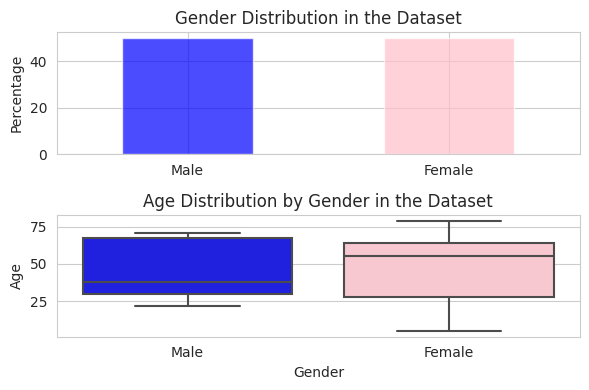

In [ ]:
# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 4))

# Bar plot for gender distribution
gender_counts = df['Gender'].value_counts(normalize=True) * 100
gender_counts.plot(kind='bar', ax=axs[0], color=['blue', 'pink'], alpha=0.7)

axs[0].set_ylabel('Percentage')
axs[0].set_title('Gender Distribution in the Dataset')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)

# Box plot for age distribution
sns.boxplot(x='Gender', y=df['Age'].astype(float), data=df, ax=axs[1], palette=['blue', 'pink'])

axs[1].set_title('Age Distribution by Gender in the Dataset')
axs[1].set_ylabel('Age')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

# Adjust layout
plt.tight_layout()
plt.savefig("scientific_figure.png", dpi=300)
plt.show()

<ipython-input-41-199509493b4f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


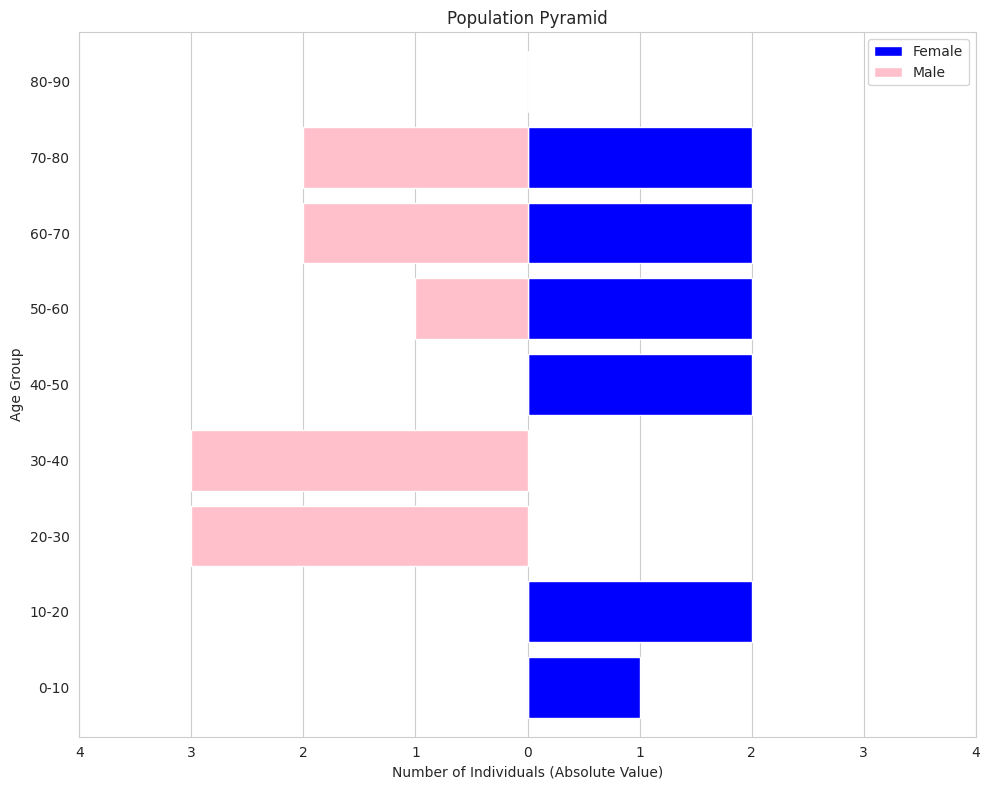

In [ ]:
# Create age bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Group by AgeGroup and Gender
grouped = df.groupby(['AgeGroup', 'Gender']).size().unstack().fillna(0)

# Make the Male group negative for the pyramid effect
grouped['Male'] = -grouped['Male']

# Create the modified population pyramid
fig, ax = plt.subplots(figsize=(10, 8))
grouped.plot(kind='barh', stacked=True, ax=ax, color=['blue', 'pink'], width=0.8)

# Set title, y-label, and x-axis limits
ax.set_title('Population Pyramid')
ax.set_ylabel('Age Group')
ax.set_xlim([-4, 4])
ax.legend(loc='upper right')

# Custom x-ticks labels
labels = [str(abs(int(label))) for label in ax.get_xticks()]
ax.set_xticklabels(labels)
ax.set_xlabel('Number of Individuals (Absolute Value)')

# Adjust the grid and display the plot
ax.grid(axis='y')
plt.tight_layout()
plt.savefig("population_pyramid_custom_xaxis.png", dpi=300)
plt.show()

# Final DataFrame

In [ ]:
# Generate the new data frame with selected columns
new_df = df[['PMID', 'Title', 'Journal', 'Year', 'Age', 'Gender', 'Visiting Reason']]

In [ ]:
# Check the length of the table. Here, I'm assuming 40 rows fit an A4 page. Adjust as necessary.
if len(new_df) <= 40:
    print("Table 1: Your table title\n")
    print(new_df)
    print("\nLegend: Your table legend (max 300 words)")
else:
    # Save to a .csv file (can be changed to .xls using `df.to_excel` if needed)
    new_df.to_csv("Table1.csv", index=False)

new_df

Table 1: Your table title

        PMID                                              Title  \
0   34976575  Primary Chondrosarcoma in L-shaped Crossed Fus...   
1   34168859  Endovascular aortic aneurysm repair with rever...   
2   30105208  About a case of ureteropelvic junction obstruc...   
4   28603157  Anatomical and Radiological Analyses of L-shap...   
6   26495075  Robot-assisted heminephrectomy for chromophobe...   
7   26066307  Right-Crossed, Fused Renal Ectopia L-Shaped Ki...   
8   25785321  Laparoscopic sigmoid colectomy for a patient w...   
9   25607413  Left crossed fused renal ectopia L-shaped kidn...   
10  25405020  Laparoscopic pyeloplasty for ureteropelvic jun...   
11  23273097  Supine percutaneous nephrolithotomy for bilate...   
12  22056611  L-shaped right-to-left crossed-fused renal ect...   
13  21035712  A case of abdominal aortic aneurysm associated...   
14  20347478  Crossed-fused renal ectopia associated with in...   
15  18692871            L-shaped cr

,PMID,Title,Journal,Year,Age,Gender,Visiting Reason
0,34976575,Primary Chondrosarcoma in L-shaped Crossed Fus...,Journal of kidney cancer and VHL,2022,50,Male,"Hematuria, increased urination frequency, burn..."
1,34168859,Endovascular aortic aneurysm repair with rever...,Journal of surgical case reports,2021,79,Female,Diagnosis of abdominal aortic aneurysm (AAA)
2,30105208,About a case of ureteropelvic junction obstruc...,Urology case reports,2018,40,Female,First visit: fever and left flank pain; Second...
4,28603157,Anatomical and Radiological Analyses of L-shap...,The Kurume medical journal,2018,79,Female,Dead
6,26495075,Robot-assisted heminephrectomy for chromophobe...,Korean journal of urology,2015,55,Female,Dull aching pain on the right side of the abdomen
7,26066307,"Right-Crossed, Fused Renal Ectopia L-Shaped Ki...",Urologia internationalis,2015,60,Female,Recurring milky urine
8,25785321,Laparoscopic sigmoid colectomy for a patient w...,International surgery,2015,71,Male,Routine medical checkup indicating sigmoid col...
9,25607413,Left crossed fused renal ectopia L-shaped kidn...,Romanian journal of morphology and embryology ...,2014,26,Male,Intermittent abdominal pain in the left flank
10,25405020,Laparoscopic pyeloplasty for ureteropelvic jun...,Korean journal of urology,2014,16,Female,Right-side lower abdominal pain with a dull ache
11,23273097,Supine percutaneous nephrolithotomy for bilate...,Urology,2013,68,Female,Lower abdominal pain persisting for 2 years


# To extract age and gender from Abstract.
## Doesn't work properly. ❌

In [ ]:
# Initialize empty lists for age and gender
age_list = []
gender_list = []

# Loop through abstracts
for abstract in df['Abstract']:
    # Extract age using regex
    age_match = re.search(r'(\d{1,3})[-\s]?year[-\s]?old', abstract)
    age = age_match.group(1) if age_match else 'Not Mentioned'

    # Determine gender based on keyword presence
    if ' male' in abstract or ' man' in abstract or ' boy' in abstract:
        gender = 'Male'
    elif ' female' in abstract or ' woman' in abstract or ' girl' in abstract:
        gender = 'Female'
    else:
        gender = 'Not Mentioned'

    age_list.append(age)
    gender_list.append(gender)

# Add the extracted age and gender information to the DataFrame
df['Age'] = age_list
df['Gender'] = gender_list

# Filter the DataFrame to only keep rows where Age and Gender are mentioned
df_filtered = df[(df['Age'] != 'Not Mentioned') & (df['Gender'] != 'Not Mentioned')]

df_filtered.to_csv('age_gender.csv')

In [ ]:
df

,Title,Abstract,Journal,Language,Year,Month,PMID,Age,Gender
0,Primary Chondrosarcoma in L-shaped Crossed Fus...,Primary renal chondrosarcomas are rare tumors ...,Journal of kidney cancer and VHL,eng,2022,NaN,34976575,Not Mentioned,Male
1,Endovascular aortic aneurysm repair with rever...,Crossed fused renal ectopia is a very rare con...,Journal of surgical case reports,eng,2021,06,34168859,79,Female
2,About a case of ureteropelvic junction obstruc...,No Abstract,Urology case reports,eng,2018,09,30105208,Not Mentioned,Not Mentioned
3,[Case report of rare co-occurrence of renal ce...,L-shaped kidney refers to a rare anomaly of th...,"Urologiia (Moscow, Russia : 1999)",rus,2017,10,29135151,Not Mentioned,Not Mentioned
4,Anatomical and Radiological Analyses of L-shap...,L-shaped kidney is a congenital anomaly. The d...,The Kurume medical journal,eng,2018,02,28603157,Not Mentioned,Female
5,Crossed fused renal ectopia in a Persian cat.,This report describes a rare case of crossed f...,JFMS open reports,eng,2017,NaN,28491454,Not Mentioned,Male
6,Robot-assisted heminephrectomy for chromophobe...,Renal cell carcinoma associated with fused ect...,Korean journal of urology,eng,2015,10,26495075,Not Mentioned,Male
7,"Right-Crossed, Fused Renal Ectopia L-Shaped Ki...",Crossed fused renal ectopia combined with chyl...,Urologia internationalis,eng,2015,NaN,26066307,Not Mentioned,Not Mentioned
8,Laparoscopic sigmoid colectomy for a patient w...,Crossed-fused renal ectopia (CFRE) is a very r...,International surgery,eng,2015,03,25785321,Not Mentioned,Not Mentioned
9,Left crossed fused renal ectopia L-shaped kidn...,Crossed fused renal ectopia (CFRE) is the seco...,Romanian journal of morphology and embryology ...,eng,2014,NaN,25607413,Not Mentioned,Not Mentioned


# Working with PDF

In [ ]:
pdf_folder_path = '/content/drive/MyDrive/CrossFused/'

## To extract age and gender from PDF.
## Doesn't work properly. ❌

In [ ]:
# Function to extract age and gender from PDF text content
def extract_age_gender_from_pdf(pdf_path):
    text = extract_text(pdf_path)

    # Extract age
    age_match = re.search(r'(\d{1,3})[-\s]?year[-\s]?old', text)
    age = age_match.group(1) if age_match else 'Not Mentioned'

    # Determine gender
    if 'male' in text or 'man' in text or 'boy' in text:
        gender = 'Male'
    elif 'female' in text or 'woman' in text or 'girl' in text:
        gender = 'Female'
    else:
        gender = 'Not Mentioned'

    return age, gender

# Assuming that each row in your DataFrame has a unique identifier that corresponds to a PDF filename
for index, row in df.iterrows():
    pdf_filename = pdf_folder_path + str(row['PMID']) + '.pdf'  # Prepending the folder path and ensuring PMID is a string

    try:
        age, gender = extract_age_gender_from_pdf(pdf_filename)

        if row['Age'] == 'Not Mentioned':
            df.at[index, 'Age'] = age

        if row['Gender'] == 'Not Mentioned':
            df.at[index, 'Gender'] = gender

    except FileNotFoundError:
        print(f"PDF for PMID {row['PMID']} not found. Skipping...")
        continue
    except Exception as e:
        print(f"Error processing PDF for PMID {row['PMID']}: {e}. Skipping...")
        continue

# Save updated DataFrame to CSV
df.to_csv('updated_age_gender.csv')

PDF for PMID 29135151 not found. Skipping...
PDF for PMID 28491454 not found. Skipping...
PDF for PMID 12768990 not found. Skipping...
PDF for PMID 11176462 not found. Skipping...
PDF for PMID 10658464 not found. Skipping...
PDF for PMID 2678982 not found. Skipping...
PDF for PMID 3250168 not found. Skipping...


## Row 17 (PMID = 16362579) presents two cases.

In [ ]:
new_row = df.loc[17].copy()

# Update the Age and Gender columns for the new row
new_row['Age'] = 42
new_row['Gender'] = 'Female'

# Append the new row to the dataframe right after row 17
df = pd.concat([df.iloc[:18], pd.DataFrame(new_row).T, df.iloc[18:]]).reset_index(drop=True)

In [ ]:
df

,Title,Abstract,Journal,Language,Year,Month,PMID,Age,Gender
0,Primary Chondrosarcoma in L-shaped Crossed Fus...,Primary renal chondrosarcomas are rare tumors ...,Journal of kidney cancer and VHL,eng,2022,NaN,34976575,50,Male
1,Endovascular aortic aneurysm repair with rever...,Crossed fused renal ectopia is a very rare con...,Journal of surgical case reports,eng,2021,06,34168859,79,Female
2,About a case of ureteropelvic junction obstruc...,No Abstract,Urology case reports,eng,2018,09,30105208,40,Male
3,[Case report of rare co-occurrence of renal ce...,L-shaped kidney refers to a rare anomaly of th...,"Urologiia (Moscow, Russia : 1999)",rus,2017,10,29135151,Not Mentioned,Not Mentioned
4,Anatomical and Radiological Analyses of L-shap...,L-shaped kidney is a congenital anomaly. The d...,The Kurume medical journal,eng,2018,02,28603157,79,Female
5,Crossed fused renal ectopia in a Persian cat.,This report describes a rare case of crossed f...,JFMS open reports,eng,2017,NaN,28491454,Not Mentioned,Male
6,Robot-assisted heminephrectomy for chromophobe...,Renal cell carcinoma associated with fused ect...,Korean journal of urology,eng,2015,10,26495075,55,Male
7,"Right-Crossed, Fused Renal Ectopia L-Shaped Ki...",Crossed fused renal ectopia combined with chyl...,Urologia internationalis,eng,2015,NaN,26066307,60,Male
8,Laparoscopic sigmoid colectomy for a patient w...,Crossed-fused renal ectopia (CFRE) is a very r...,International surgery,eng,2015,03,25785321,71,Male
9,Left crossed fused renal ectopia L-shaped kidn...,Crossed fused renal ectopia (CFRE) is the seco...,Romanian journal of morphology and embryology ...,eng,2014,NaN,25607413,26,Male


In [ ]:
case_reports[25]

'X'

In [ ]:
len(df)

27